<a href="https://colab.research.google.com/github/manlio99/Materia-de-aprendizaje/blob/master/4_DataWrangling/8_outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outlier Detection / Detección de valores atípicos

In [1]:
# Usaremos las siguientes bibliotecas
# Datos
import numpy as np 
import pandas as pd 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Univariante

### Métodos paramétricos

Primero, creemos un marco de datos con datos ficticios donde las características tienen ** distribuciones normales ** para explorar métodos paramétricos univariados para la detección de valores atípicos.

In [2]:
# Semilla aletoria
np.random.seed(1)
features_number = 4
dummy_df = pd.DataFrame(np.random.normal(scale=10.0, size=(1000, features_number)),
                        columns=['feature{}'.format(i) for i in range(features_number)])
dummy_df

,feature0,feature1,feature2,feature3
0,16.243454,-6.117564,-5.281718,-10.729686
1,8.654076,-23.015387,17.448118,-7.612069
2,3.190391,-2.493704,14.621079,-20.601407
3,-3.224172,-3.840544,11.337694,-10.998913
4,-1.724282,-8.778584,0.422137,5.828152
...,...,...,...,...
995,-1.388814,26.521397,-6.562470,2.795620
996,-6.077151,7.298136,-8.871875,0.773272
997,0.734163,4.160262,-18.792000,5.754588
998,1.020624,11.843037,-7.948430,-1.259031


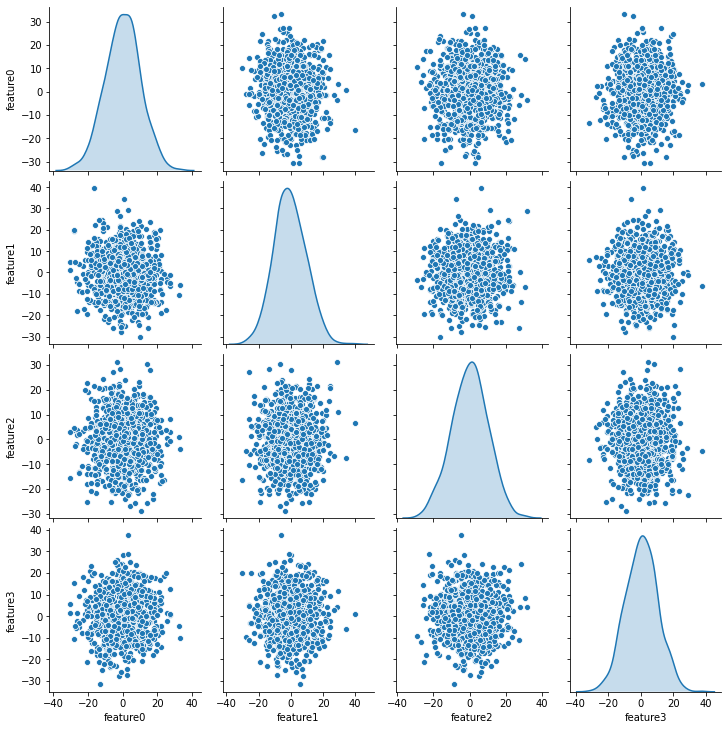

In [3]:
# destacar que la información sigue una distribución normal
sns.pairplot(dummy_df, diag_kind="kde")

In [4]:
# Los datos tienen suficiente variación entre características para tener algunos valores atípicos
dummy_df.describe()

,feature0,feature1,feature2,feature3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.130295,-0.467723,0.163857,0.649251
std,10.144231,9.967537,9.940642,9.869792
min,-30.641414,-30.160320,-28.720503,-31.533575
25%,-6.542388,-7.276946,-6.570169,-6.132045
50%,0.225131,-0.939612,0.371522,0.828764
75%,6.670833,6.081050,6.728782,7.298686
max,33.210788,39.586027,31.350473,37.402489


Una forma de detectar valores atípicos es calculando la media y la __desviación estándar__ en los datos. Luego, podemos marcar como valores atípicos todas las observaciones que estén a más de *nstd* unidades de desviación de la media:

In [5]:
# calcular media y sdt
feature = 'feature0'
data_mean, data_std = dummy_df[feature].mean(), dummy_df[feature].std()
print("feature0 mean:{} std:{}".format(data_mean, data_std))

feature0 mean:0.13029500275266578 std:10.144231491155765


In [6]:
# Distancia desde la media
nstd = 3.0
dist = data_std * nstd

# limites
lower_bound, upper_bound = data_mean - dist, data_mean + dist
print('[',lower_bound,',',upper_bound,']')

[ -30.30239947071463 , 30.562989476219958 ]


In [7]:
# Máscara atípica, Verdadera = atípico
outliers_mask = [True if x < lower_bound or x > upper_bound else False for x in dummy_df[feature]]
print("Outliers:\n{}".format(dummy_df[feature][outliers_mask]) )

Outliers:
183    33.210788
223   -30.537644
567   -30.641414
762    32.383432
Name: feature0, dtype: float64


También podemos visualizar valores atípicos en la distribución. [histograma](https://seaborn.pydata.org/generated/seaborn.distplot.html):

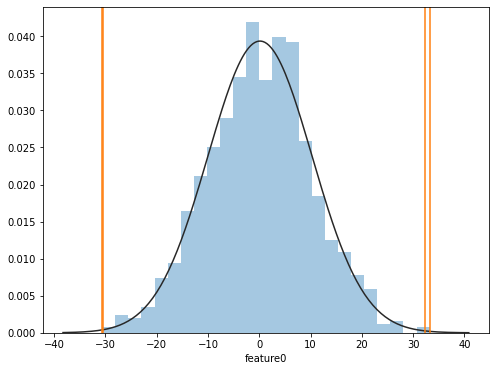

In [8]:
# Normal fitting for reference curve
from scipy.stats import norm

# Plot the distribution histogram and highlight outliers in red
plt.figure(figsize=(8,6))
sns.distplot(dummy_df[feature], fit=norm ,kde=False);
for outlier in dummy_df[feature][outliers_mask]:
    plt.axvline(outlier, 0, dummy_df[feature].max(), color = '#FF7F0E')

Un método alternativo es detectar valores atípicos calculando *Q25-Q75* __rango intercuartil(IR)__. Luego, podemos marcar como valores atípicos todas las observaciones que estén a más de $ k * IR $ unidades de *Q25* y *Q75*: 

In [9]:
#Calcular rango intercuartil
q25, q75 = np.percentile(dummy_df[feature], 25), np.percentile(dummy_df[feature], 75)
iqr = q75 - q25
iqr

13.213220892526852

In [10]:
# Calcule el rango de valores atípicos
k = 1.5
range_ir = iqr * k

# Límites
lower_bound_ir, upper_bound_ir = q25 - range_ir, q75 + range_ir

In [11]:
# Máscara atípica, Verdadera = atípico
outliers_mask_ir = [True if x < lower_bound_ir or x > upper_bound_ir else False for x in dummy_df[feature]]
print("Outliers:\n{}".format(dummy_df[feature][outliers_mask_ir]) )

Outliers:
63    -27.930850
183    33.210788
223   -30.537644
244   -26.641259
427   -27.914440
567   -30.641414
684    27.294621
762    32.383432
771   -26.768414
783   -27.391417
969    27.061249
976    27.421552
Name: feature0, dtype: float64


Visualicemos ahora los valores atípicos en la distribución [histograma](https://seaborn.pydata.org/generated/seaborn.distplot.html) y [boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html):

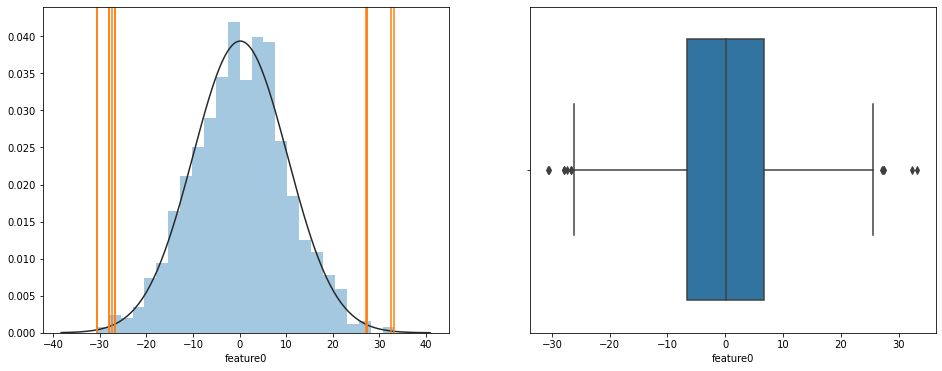

In [12]:
# Trace el histograma de distribución y resalte los valores atípicos en rojo
plt.figure(figsize=(16,6))
ax1=plt.subplot(1, 2, 1)

sns.distplot(dummy_df[feature], fit=norm ,kde=False, ax = ax1);
for outlier in dummy_df[feature][outliers_mask_ir]:
    plt.axvline(outlier, 0, dummy_df[feature].max(), color = '#FF7F0E')
    
ax2=plt.subplot(1, 2, 2)
sns.boxplot(x=dummy_df[feature], whis=k, ax = ax2)

### Métodos no paramétricos

Para explorar métodos no paramétricos, usaremos el [Melbourne Housing dataset](https://www.kaggle.com/anthonypino/melbourne-housing-market):

In [13]:
df_housing = pd.read_csv('https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/4_DataWrangling/data/Melbourne_housing_FULL.csv')
df_housing.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34856.000000,34856.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000
mean,3.031012,1.050173e+06,11.184929,3116.062859,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306
std,0.969933,6.414671e+05,6.788892,109.023903,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


Completemos los valores faltantes con el valor mediano en cada columna. Usamos [`pandas.DataFrame.fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html).

In [14]:
df_housing.fillna(df_housing.median(), inplace=True)

Graficar la distribución de datos:

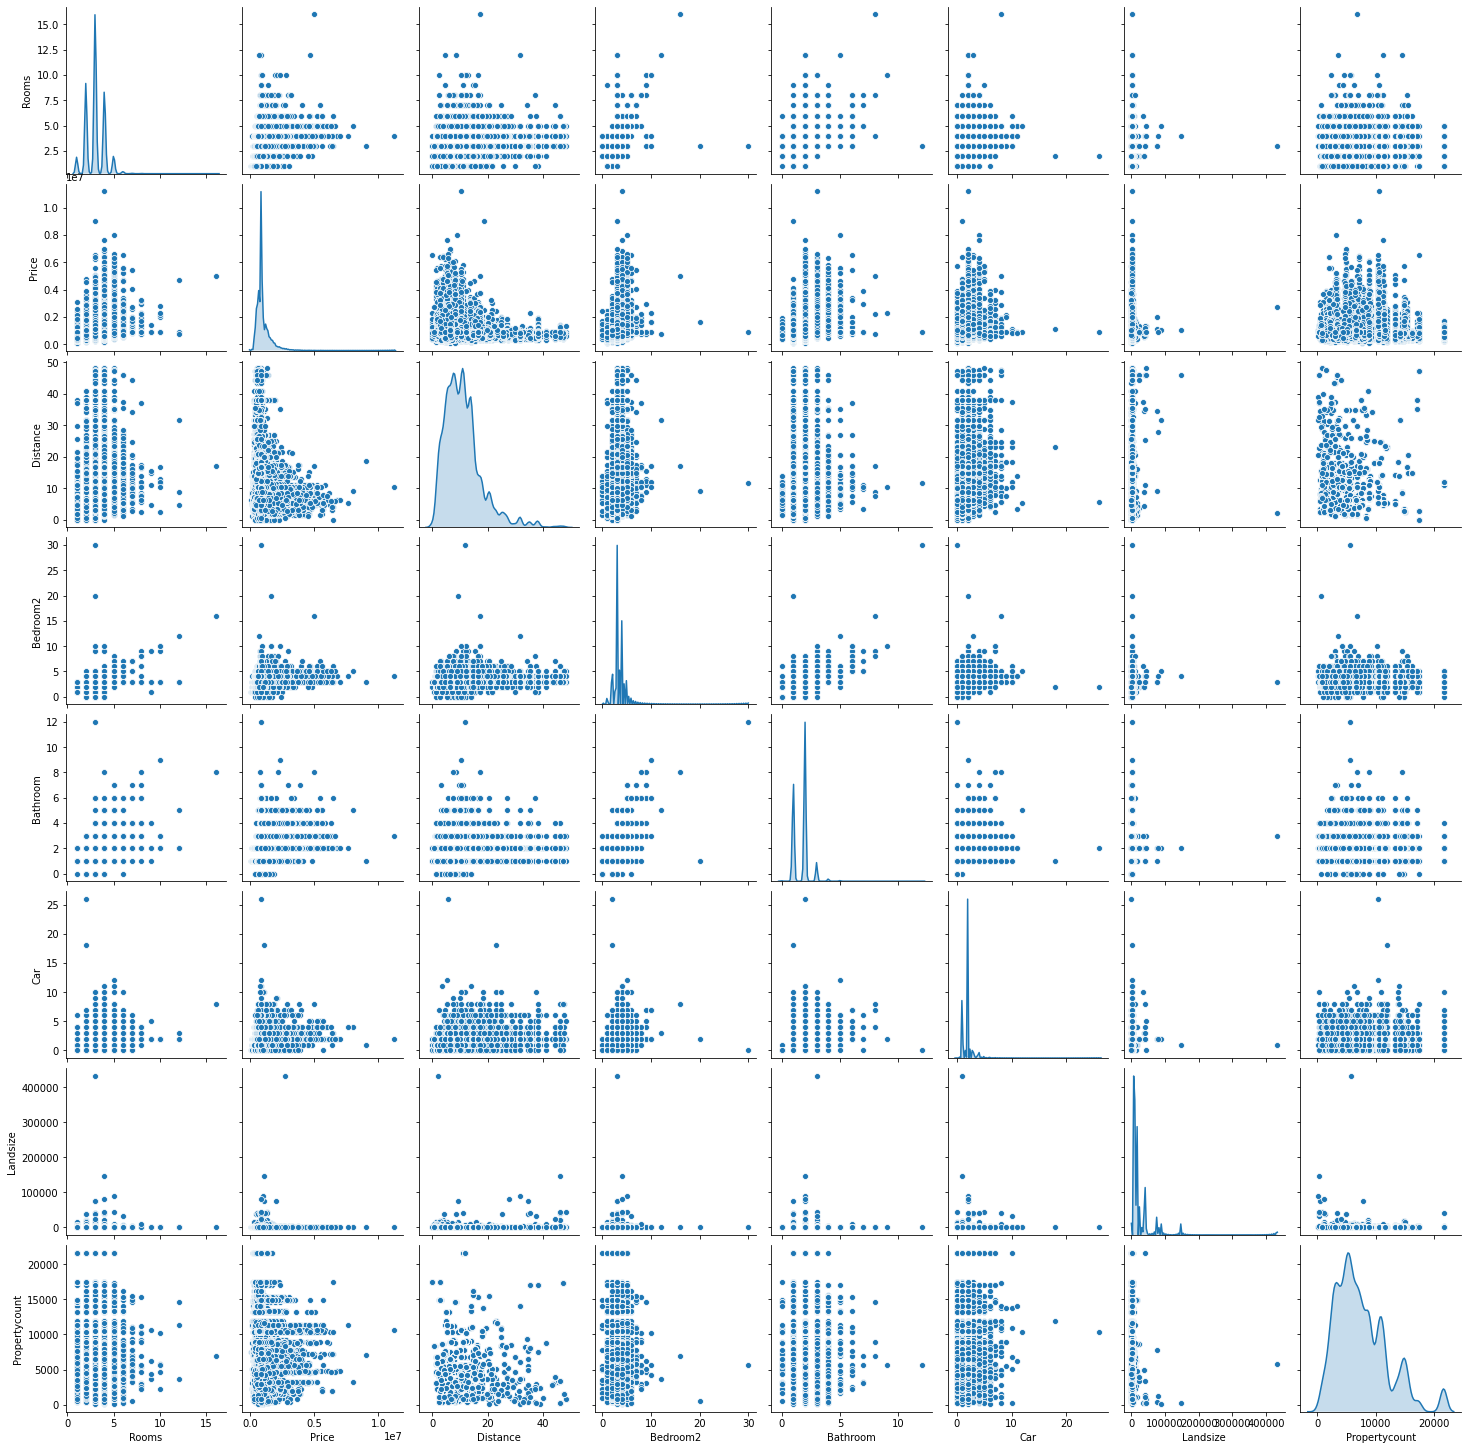

In [15]:
cols = ['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Propertycount']
sns.pairplot(df_housing[cols], diag_kind="kde")

El [algoritmo de bosque de aislamiento](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest) aísla las observaciones seleccionando aleatoriamente una característica y luego seleccionando aleatoriamente una división valor entre los valores máximo y mínimo de la característica seleccionada. El número de divisiones necesarias para aislar una muestra es notablemente menor para las anomalías. La implementación de Scikit-learn de este algoritmo devuelve una puntuación de anomalía de cada muestra:

In [16]:
from sklearn.ensemble import IsolationForest

# Valores atípicos en la columna Habitaciones
column = 'Rooms'

# ajustar 
isolation_forest = IsolationForest(contamination='auto',random_state=0)
isolation_forest.fit(df_housing[column].values.reshape(-1,1))

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

Una vez ajustados, podemos predecir la puntuación de anomalía para los datos de la columna, o incluso valores nuevos.

In [17]:
# Nuevas muestras en el rango de valores de Habitaciones
xx            = np.linspace(df_housing[column].min(), df_housing[column].max(), len(df_housing)).reshape(-1,1)

# Predecir anomaly_score usando bosque de aislamiento
anomaly_score = isolation_forest.decision_function(xx)
outlier       = isolation_forest.predict(xx)

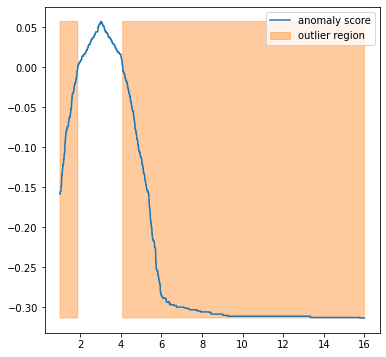

In [18]:
# Gráfico de valores atípicos
plt.figure(figsize=(6,6))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='#FF7F0E', 
                 alpha=.4, label='outlier region')
plt.legend()

Observe que Isolation Forest marca como un valor atípico cualquier casa con menos de 2 habitaciones y más de 4.

## Métodos Multivarido

### Métodos paramétricos

En el contexto multivariado, los métodos paramétricos como [Elliptic Envelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) se pueden utilizar para detectar y eliminar valores atípicos en un conjunto de datos distribuidos de Gauss. Regresemos a nuestro `dummy_df` y eliminemos los valores atípicos mirando varias columnas simultáneamente:

In [19]:
dummy_df

,feature0,feature1,feature2,feature3
0,16.243454,-6.117564,-5.281718,-10.729686
1,8.654076,-23.015387,17.448118,-7.612069
2,3.190391,-2.493704,14.621079,-20.601407
3,-3.224172,-3.840544,11.337694,-10.998913
4,-1.724282,-8.778584,0.422137,5.828152
...,...,...,...,...
995,-1.388814,26.521397,-6.562470,2.795620
996,-6.077151,7.298136,-8.871875,0.773272
997,0.734163,4.160262,-18.792000,5.754588
998,1.020624,11.843037,-7.948430,-1.259031


In [20]:
# Importar envolvente elíptica
from sklearn.covariance import EllipticEnvelope

# Ajustar las dos primeras características en dummy_df
clf = EllipticEnvelope()
clf.fit(dummy_df.values[:,:2])

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
                 store_precision=True, support_fraction=None)

Trace la envolvente elíptica ajustada. Todo lo que esté fuera de la línea discontinua se considera un valor atípico.

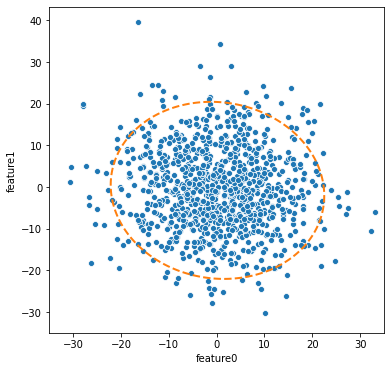

In [21]:
# Trazando la elipse
xx, yy = np.meshgrid(np.linspace(-35, 35, 500), np.linspace(-35, 35, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(6,6))
sns.scatterplot(x="feature0", y="feature1", data=dummy_df)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='#FF7F0E', linestyles='dashed')

Observe que ajustamos una envolvente elíptica a los datos bidimensionales para poder visualizarlos fácilmente. Sin embargo, puede usarlo para ajustar datos con más de dos dimensiones. 

### Métodos no paramétricos

Los algoritmos de agrupamiento a menudo se pueden usar para detectar otuliers. Tal es el caso del clustering espacial basado en Densidad de aplicaciones con ruido __ (DBSCAN) __ implementado en [`sklearn.cluster.DBSCAN ()`](https://scikit-learn.org/stable/modules/generated/ sklearn.cluster.DBSCAN.html). Es un método no paramétrico muy rápido que se puede utilizar en análisis multivariados. Los clústeres de salida se verán afectados significativamente por `eps` y` min_samples`. Sigamos un ejemplo usando nuestros datos de vivienda.

In [22]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Cuando se trabaja con problemas de agrupación en clústeres, escalar los datos es crucial
df_housing_scaled = StandardScaler().fit_transform(df_housing[cols].values)

# ajustar
db = DBSCAN(eps=3.0, min_samples=10).fit(df_housing_scaled)
labels = db.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
# Cuente el número de valores atípicos de las etiquetas de muestra (= -1) 
pd.Series(labels).value_counts() 

 0    34797
-1       60
dtype: int64

Visualicemos valores atípicos. Observe que estamos inspeccionando relaciones por pares entre *precio* y otras dimensiones del conjunto de datos:

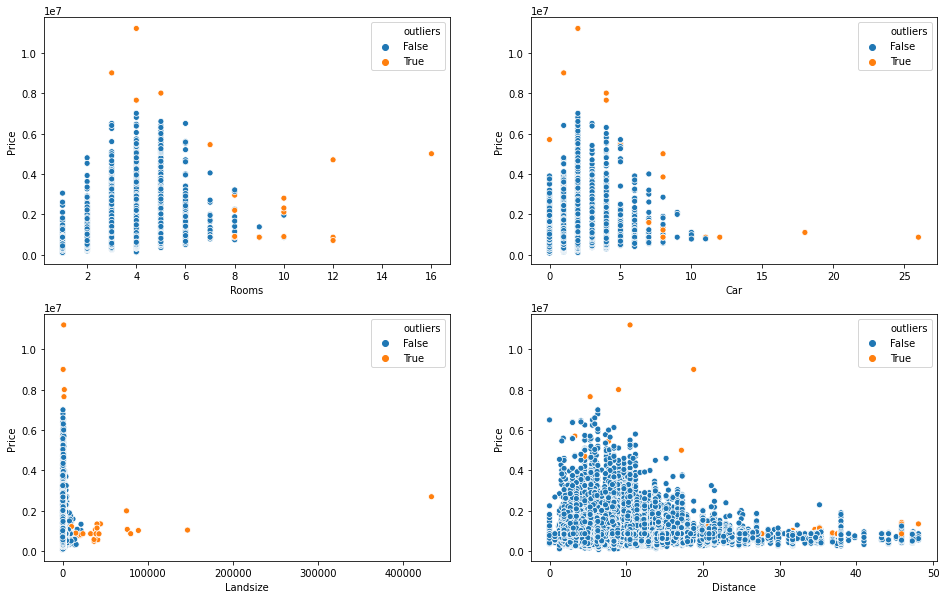

In [24]:
plt.figure(figsize=(16,10))
df_housing_outlier = df_housing
df_housing_outlier['outliers'] = [True if l == -1 else False for l in labels]

ax1=plt.subplot(2, 2, 1)
sns.scatterplot(x="Rooms", y="Price", hue='outliers', data=df_housing_outlier,ax=ax1)
ax2=plt.subplot(2, 2, 2)
sns.scatterplot(x="Car", y="Price", hue='outliers', data=df_housing_outlier,ax=ax2)
ax3=plt.subplot(2, 2, 3)
sns.scatterplot(x="Landsize", y="Price", hue='outliers', data=df_housing_outlier,ax=ax3)
ax4=plt.subplot(2, 2, 4)
sns.scatterplot(x="Distance", y="Price", hue='outliers', data=df_housing_outlier,ax=ax4)